# Training in mini-batches

## Why minibatch vs batch gradient descent?

Sometimes we have so much data that it will not fit on our GPU, which typically has around 12G of RAM.  For big problems, we need to break it up into batches.
 
Also, and possibly a more important goal, is to get better generalization; i.e., smaller validation loss. We want batch size to be as large as possible for efficiency on GPUs, but as small as possible to get the stochastic bouncing around down into lower minima.

* [Tradeoff batch size vs. number of iterations to train a neural network](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
* [Why mini batch size is better than one single “batch” with all training data?](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data)
* [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612)

In [1]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [2]:
def plot_history(history, ax=None, maxy=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_accur))
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

In [3]:
d = load_diabetes()
len(d.data)

442

In [4]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [26]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [27]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [28]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 452.46 validation MSE 3823.18


In [29]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Minibatch stochastic gradient descent (SGD)

In [30]:
def sgdtrain(model, X_train, X_test, y_train, y_test,
             learning_rate = .5, nepochs=2000, weight_decay=0, batch_size=32,
             trace=True):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    history = []
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            loss = 0
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            loss = torch.mean((y_pred - batch_y)**2)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()
        
        epoch_training_loss /= nbatches # average batch loss

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((epoch_training_loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {epoch_training_loss:12.3f}   test loss {loss_test:12.3f}")

    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    29367.054   test loss    31434.738
Epoch  100 MSE train loss     2974.861   test loss     4313.362
Epoch  200 MSE train loss     2950.836   test loss     3769.297
Epoch  300 MSE train loss     2351.328   test loss     3784.280
Epoch  400 MSE train loss     2551.195   test loss     3826.031
Epoch  500 MSE train loss     2298.552   test loss     3877.779
Epoch  600 MSE train loss     2366.596   test loss     3923.149
Epoch  700 MSE train loss     2375.204   test loss     3967.121
Epoch  800 MSE train loss     2509.960   test loss     3959.647
Epoch  900 MSE train loss     2278.510   test loss     4019.627
Epoch 1000 MSE train loss     2655.767   test loss     4056.558
BEST MSE test loss 3719.921
MSE test loss 3719.921


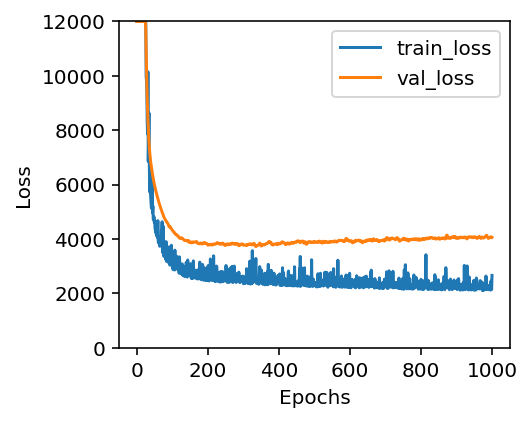

In [38]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
#    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                               learning_rate=.001, nepochs=1000, batch_size=32)

# verify we got the best model out
y_pred = best_model(X_test)
best_loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {best_loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))

Epoch    0 MSE train loss     5499.364   test loss     4277.796
Epoch   10 MSE train loss     2736.006   test loss     5369.228
Epoch   20 MSE train loss     2505.952   test loss     4032.110
Epoch   30 MSE train loss     2485.501   test loss     4409.367
Epoch   40 MSE train loss     2258.681   test loss     4879.033
Epoch   50 MSE train loss     2074.556   test loss     4867.797
Epoch   60 MSE train loss     2062.846   test loss     5515.391
Epoch   70 MSE train loss     1994.107   test loss     4693.574
Epoch   80 MSE train loss     1846.515   test loss     5357.036
Epoch   90 MSE train loss     1950.549   test loss     5141.047
Epoch  100 MSE train loss     1840.495   test loss     5649.998
BEST MSE test loss 4023.402
Epoch    0 MSE train loss    12265.790   test loss     5469.163
Epoch   10 MSE train loss     2953.317   test loss     3982.574
Epoch   20 MSE train loss     3014.110   test loss     4975.932
Epoch   30 MSE train loss     2904.299   test loss     4140.840
Epoch   40 M

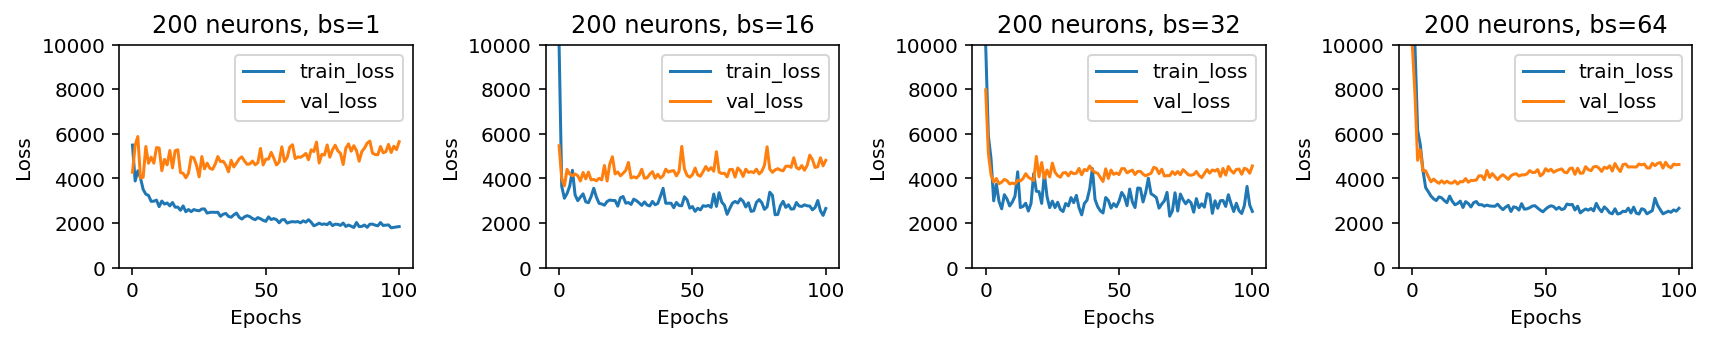

In [41]:
fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

n_neurons = 200
for bs,ax in zip([1,16,32,64],axes):
    if bs>1:
        model = nn.Sequential(
            nn.Linear(ncols, n_neurons),
            nn.BatchNorm1d(n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 1)
        )
    else:
        model = nn.Sequential(
            nn.Linear(ncols, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 1)
        )
    history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                                   learning_rate=.05, nepochs=100, batch_size=bs,
                                   trace=True)
    ax.set_title(f"{n_neurons} neurons, bs={bs}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()